In [1]:
import numpy as np
from math import sin, cos, sqrt
from scipy.optimize import fmin_bfgs

# PA1.1

In [2]:
def minimizer(func, current_position, learning_rate, converge_threshold):
    steps = 0
    while True:
        y = func.val(current_position)
        current_position -= learning_rate * func.grad(current_position)
        steps += 1
        if abs(func.val(current_position) - y) < converge_threshold:
            return current_position, steps

------

# PA1.2

In [3]:
# helper methods

def pretty_print_params(func, start_positions, learning_rate, threshold, full_output):
    # helper function which pretty prints parameters
    positions = np.copy(start_positions)
    end_position, total_steps = minimizer(
        func, positions, learning_rate, threshold)
    if full_output:
        print('Starting at {}, with learning rate {} and converge threshold {}'.format(
            start_positions, learning_rate, threshold))
        print('ended up at {} in {} steps.\n'.format(end_position, total_steps))
    return end_position, total_steps


def test_params(func, full_output=0):
    print_output = lambda x: print(x) if full_output else 0
    # helper function with parameter testings
    P_error, total_steps = 0, 0
    print_output('######### Testing with Step Size #########')
    for learning_rate in [.9, .7, .5, .3, .1, .05, .01, .001]:
        p, step = pretty_print_params(func, np.array(
            (10.0, 10.0)), learning_rate, 0.0001, full_output)
        P_error += abs(p[0]-10.0)
        total_steps += step

    print_output('######### Testing with Starting Positions #########')
    for s in [(1000.0, 1000.0), (100.0, 100.0), (10.0, 10.0), (1.0, 1.0), (-20.0, -20.0)]:
        p, step = pretty_print_params(func, np.array(s), 0.2, 0.0001, full_output)
        P_error += abs(p[0]-s[0])
        total_steps += step
        
    print_output('######### Testing with Convergence Criterion #########')
    for threshold in [0.9, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
        p, step = pretty_print_params(func, np.array((1.0, 1.0)), 0.2, threshold, full_output)
        P_error += abs(p[0]-s[0])
        total_steps += step
        
    print("Total Error: {:.2f} Total Steps: {}".format(P_error, total_steps))

In [4]:
# Quadratic Bowl, which optimal value we know to be [0, 0]

class Quadratic_Bowl:
    val = lambda X: X[0]**2 + X[1]**2
    grad = lambda X: np.array((2*X[0], 2*X[0]))
test_params(Quadratic_Bowl, full_output=False) # change full_output to True to see each test

Total Error: 1351.57 Total Steps: 2808


### for test_params, change full_output to True to see each test

In [5]:
# The Drop Wave Function, with way too many local minima
# which global minima we know also to be [0, 0]

class Drop_Wave:

    def val(X):
        t = X[0]**2 + X[1]**2
        return - (1 + cos(12 * sqrt(t))) / (0.5 * (t) + 2)

    def grad(X):
        t = X[0]**2 + X[1]**2
        g = lambda x: (-12*sin(12*sqrt(t))*(0.5*sqrt(t)+2)-x *
                       cos(12*sqrt(t)+1)*sqrt(t))/(0.5*t+2)**2*sqrt(t)
        return np.array((g(X[0]), g(X[1])))
    
test_params(Drop_Wave, full_output=False)

Total Error: 142.24 Total Steps: 181


#### Initial Guesses:
- The more closer to minima, the quicker the convergence.
- If close to local minima (instead of global minima), will get stuck in local minima

#### Learning Rate:
- Small step size takes incredible amount of time, also requires small convergence threshold to guarantee accuracy
- When small, increased step_size gets to local minima faster (with fewer steps); 
- After some point, with increase of step_size, more steps are required since step wabbles around minima before converge. if too big, never converge.
- However, if step_size is too small, not only it takes too many steps to converge, the accuracy drops (assuming no change in convergence threshold) because small Learning Rate means small step size, hence easier to drop within convergence threshold.
- Small Learning Rate is prone of falling into local minima, even obvious ones.

#### Convergence Criterion
- Small threshold helps with faster convergence (although hurts accuracy).
- Small threshold is required when learning rate is small.
- Small threshold (together with normal learning rate) helps stay away from local minimas that are not so steep 

------

# PA1.3

In [6]:
def Central_Differentiate(func, X, h):
    G = np.zeros(len(X))
    for i in range(len(X)):
        X[i] += h
        f_x_plus_h = func(X)
        X[i] -= 2 * h
        f_x_minus_h = func(X)
        X[i] += h
        G[i] = (f_x_plus_h - f_x_minus_h) / (2 * h)
    return G

# overwrite the analytical gradient minimizer as a numerical one.
def minimizer(func, current_position, learning_rate, converge_threshold):
    steps = 0
    while True:
        y = func(current_position)
        current_position -= learning_rate * Central_Differentiate(func, current_position, 0.0001)
        steps += 1
        if abs(func(current_position) - y) < converge_threshold:
            return current_position, steps

In [7]:
# quadratic bowl with numerical minimizer.

Quadratic_Bowl = lambda X: X[0]**2 + X[1]**2
#     grad = lambda X: Central_Differentiate(Quadratic_Bowl_numerical.val, X, 0.0001)
    
test_params(Quadratic_Bowl, full_output=False)

Total Error: 1351.57 Total Steps: 2808


In [8]:
# the drop wave function
def Drop_Wave(X):
    t = X[0]**2 + X[1]**2
    return - (1 + cos(12 * sqrt(t))) / (0.5 * (t) + 2)
#     grad = lambda X: Central_Differentiate(Drop_Wave_numerical, X, 0.0001)
    
test_params(Drop_Wave, full_output=False)

Total Error: 136.22 Total Steps: 1564


- for simple quadratic bowl, the only noticeable different is when analytic minimizer accidentally hit exactly [0, 0] (initial position at [10,10] with learning rate 0.7 and threshold 0.0001), the numerical minimizer, although extremely close, returned [  1.45583788e-21   1.45583788e-21]
- numerical minimizer achieved total success when dealing with the Drop Wave Function. Since Drop Wave function has so many shallow local minimas, the analytics minimizer always stuck in one near initial guess with few exceptions where carefully adjusting Learning Rate and Threshold was being done. On the contrary, in the numerical case, where a comparably large `h` (0.1) overlooks local dips and in some sense smoothed the surface, averaging the gradient within `2h` range, overcome the difficulty where tiny minimas are everywhere.


------

# PA1.4

In [9]:
class Quadratic_Bowl_with_counts:

    def __init__(self):
        self.call_count = 0

    def val(self, X):
        self.call_count += 1
        return X[0]**2 + X[1]**2
    
    
class Drop_Wave_with_counts:
    def __init__(self):
        self.call_count = 0
    def val(self, X):
        self.call_count += 1
        t = X[0]**2 + X[1]**2
        return - (1 + cos(12 * sqrt(t))) / (0.5 * (t) + 2)
    

Func = Quadratic_Bowl_with_counts()
test_params(Func.val, full_output=False)
print('funcation called {} times.'.format(Func.call_count))  # funcation called 5616 times.

Func = Drop_Wave_with_counts()
test_params(Func.val, full_output=False)
print('funcation called {} times.'.format(Func.call_count)) # funcation called 3128 times.


Total Error: 1351.57 Total Steps: 2808
funcation called 16848 times.
Total Error: 136.22 Total Steps: 1564
funcation called 9384 times.


In [10]:
# saving my naive minimizer
my_minimizer = minimizer

# overwriting my minimizer by packaging scipy.optimize.fmin_bfgs
# so that we can still use all the helper functions
def minimizer(func, current_position, learning_rate, converge_threshold):
    # function signature for fmin_bfgs function
    min_x,_,_,_,_,step,_ = fmin_bfgs(func, current_position, epsilon=learning_rate, gtol=converge_threshold, full_output=1, disp=0)
    return min_x, step

Func = Quadratic_Bowl_with_counts()
test_params(Func.val)
print('funcation called {} times.'.format(Func.call_count))  # funcation called 312 times.

Func = Drop_Wave_with_counts()
test_params(Func.val)
print('funcation called {} times.'.format(Func.call_count))  # funcation called 5745 times.

Total Error: 1352.27 Total Steps: 78
funcation called 312 times.
Total Error: 147.66 Total Steps: 1386
funcation called 5745 times.


- As shown in code, the ratio of calls is approximately 54/1 (my minimizer 16848 / scipy minimizer 312) for Quadratic Bowl. For Drop Wave, the ratio is much more closer to 1 (9384/5745) due to tramendous amount of local mimimas.

- However, in the complicated case, the Drop Wave function, we see a dramatic increase in function calls along with increase in accuracy caused by breaking out of local minimas.


- Furthermore, the scipy optimizer ignores with local minimas almost everytime, even for all the Drop Wave Function cases. I was deeply impressed.

------

# PA2.1

In [11]:
# professor's code
import pylab as pl

def regressionPlot(X, Y, order):
    pl.plot(X.T.tolist()[0],Y.T.tolist()[0], 'gs')
    phi = designMatrix(X.T[0], order)
    
    # compute the weight vector
    w, c = regressionFit(phi, Y)

    print('W =',w)
    # produce a plot of the values of the function 
    pts = pl.linspace(min(X), max(X), 100)
    Yp = pl.dot(w.T, designMatrix(pts, order).T)
    pl.plot(pts, Yp)
    pl.show()

def getData(filename):
    data = pl.loadtxt(filename)
    X = data[0:1].T
    Y = data[1:2].T
    return X, Y

In [12]:
# functions required to complete professor's visualization code

def designMatrix(X, M):
    return np.array([[x**(m) for m in range(M+1)] for x in X])

def regressionFit(X, Y):
    # applying the Normal Equation to get optimal weight
    return np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y.T[0])), 0

when M = 0:
W = [ 0.1862995]


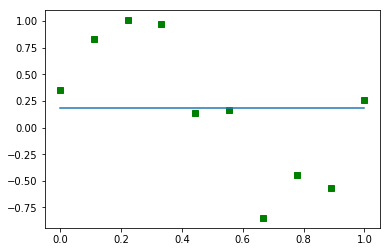

when M = 1:
W = [ 0.82021246 -1.26782593]


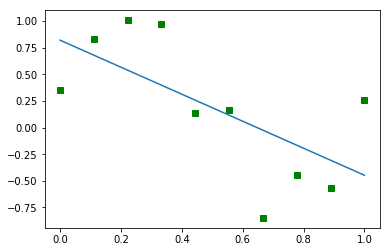

when M = 3:
W = [  0.31370273   7.98537103 -25.42610224  17.37407653]


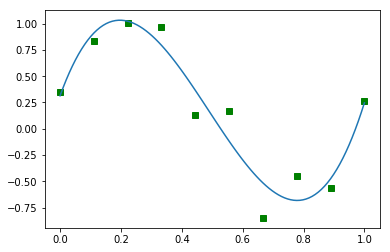

when M = 9:
W = [  3.49512436e-01   2.32326298e+02  -5.32086773e+03   4.85596769e+04
  -2.31598783e+05   6.39931981e+05  -1.06162004e+06   1.04222515e+06
  -5.57590377e+05   1.25180846e+05]


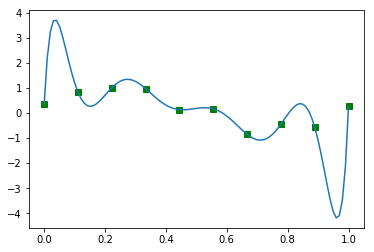

In [13]:
%matplotlib inline 
x_train, y_train = getData('curvefitting.txt')

for m in (0,1,3,9):
    print('when M = {}:'.format(m))
    regressionPlot(x_train, y_train, m)

------

# PA2.2

In [14]:
def getPolynomialError(X, Y):
    # return error function for polynomial which is expanded to the power of M
    # which is sum of square of (yi - W·x[i])
    # return value being a function for later usage in fmin_bfgs
    return lambda W: sum((Y[i] - np.dot(W, X[i]))**2 for i in range(len(Y)))


In [15]:
def SSE(X, Y, M, W):
    return getPolynomialError(designMatrix(X, M), Y)(W)

def SSE_grad(X, Y, M, W):
    X = designMatrix(X, M)
    return sum(np.dot(X[i], np.dot(W, X[i])-Y[i]) for i in range(len(X))) *2

In [16]:
def compare_gradient():
    for m in (1, 3, 6, 9):
        print('for M = {}:'.format(m))
        some_initial_guess = [100] * (m + 1)
        analytical_grad = SSE_grad(x_train.T[0], y_train.T[0], m, some_initial_guess)
        numerical_grad = Central_Differentiate(
            getPolynomialError(designMatrix(x_train.T[0], m), y_train.T[0]), 
            some_initial_guess, 
            0.0001) # h = 0.0001
        # adding and print absolute sum of difference in gradiences 
        print('total difference:', sum(np.absolute(analytical_grad - numerical_grad)))

compare_gradient()

for M = 1:
total difference: 1.55451743922e-07
for M = 3:
total difference: 8.58420662553e-07
for M = 6:
total difference: 4.51957384939e-06
for M = 9:
total difference: 7.97700340627e-06


- Very minor differences observed

----

# PA2.3

when M = 0:
W = [ 0.1863506]


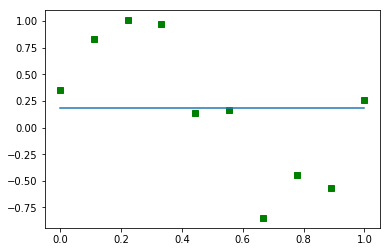

when M = 1:
W = [ 0.81578498 -1.25968013]


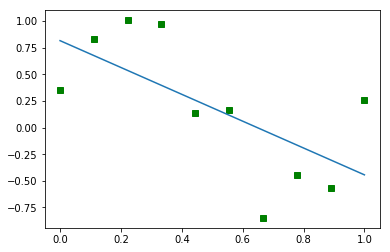

when M = 3:
W = [  0.42008194   6.41016135 -21.46034571  14.80325791]


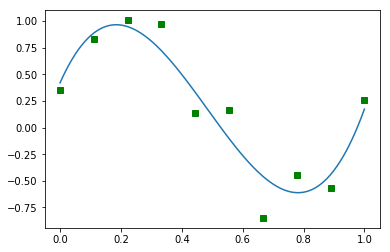

when M = 9:
W = [ 0.45704167  4.13145229 -8.93044229 -3.05709922  1.86222864  3.6942552
  3.31939039  1.7384823  -0.36510513 -2.58736858]


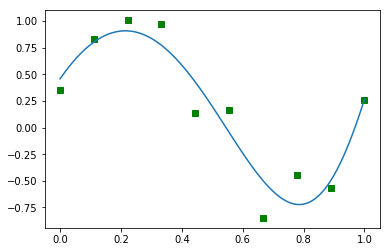

In [17]:
def regressionFit(phi, Y):
    W =  [100.0] * len(phi[0]) # hardcoding initial guess to be all 100, although doesn't matter
    return my_minimizer(getPolynomialError(phi, Y), W, 0.04, 0.00001)

for m in (0,1,3,9):
    print('when M = {}:'.format(m))
    regressionPlot(x_train, y_train, m)

- Note that with the right parameter, the power explosion can be avoided, although requires low convergence threshold, increasing the amount of time needed to converge. The above minimizer is using learning rate 0.04, converge threshold 0.0001

In [18]:
def regressionFit(phi, Y):
    W =  [100.0] * len(phi[0]) # hardcoding initial guess to be all 100, although doesn't matter
    return fmin_bfgs(getPolynomialError(phi, Y), W, disp=0), 0

when M = 0:
W = [ 0.18629949]


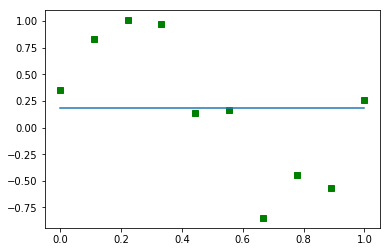

when M = 1:
W = [ 0.82021245 -1.26782592]


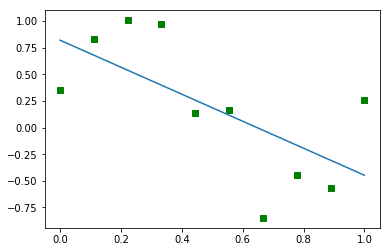

when M = 3:
W = [  0.31370297   7.98536143 -25.4260779   17.37406078]


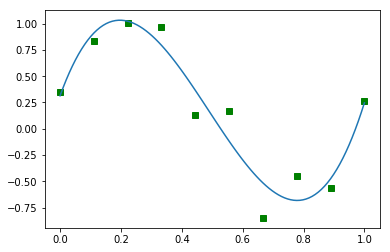

when M = 9:
W = [  3.45268151e-01   7.40016892e+00  -3.72194682e+01   1.30637732e+02
  -2.73235047e+02   9.60095958e+01   2.96549820e+02  -4.84142000e+01
  -4.16140980e+02   2.44324521e+02]


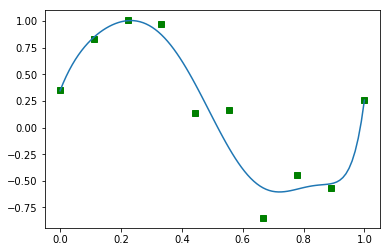

In [19]:
for m in (0,1,3,9):
    print('when M = {}:'.format(m))
    regressionPlot(x_train, y_train, m)

- Note that with sophisticated optimizer, a more "natural" effect was achieved in the M=9 case.
- One can still argue it is overfitting (in m=9 case), but it is certainly not overfitting too much given that 9th power of polynomial is so prone to overfit.

----

# PA3.1

when M = 3 and lambda = 0.01:
W = [ 0.85708346 -0.4985194  -3.65863895  3.11370291]


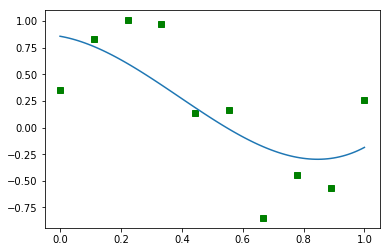

when M = 3 and lambda = 0.1:
W = [ 0.85708346 -0.4985194  -3.65863895  3.11370291]


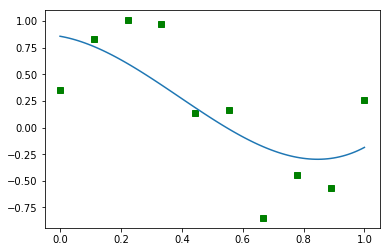

when M = 9 and lambda = 0.01:
W = [ 0.68873764  0.93157011 -2.95335993 -1.75990802 -0.34659638  0.51934785
  0.89337297  0.94231087  0.8025802   0.56583082]


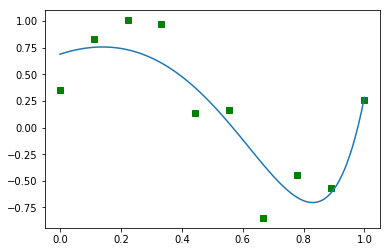

when M = 9 and lambda = 0.1:
W = [ 0.68873764  0.93157011 -2.95335993 -1.75990802 -0.34659638  0.51934785
  0.89337297  0.94231087  0.8025802   0.56583082]


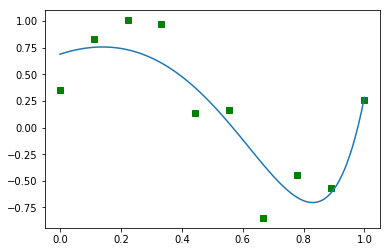

In [20]:
# analytical solution
def regressionFit(X, Y):
    # applying the Ridge Regression Equation to get optimal weight
    return np.dot(np.linalg.inv(0.01 * np.identity(len(X[0])) + np.dot(X.T,X)),np.dot(X.T,Y.T[0])), 0

for m in (3,9):
    for lmbda in (0.01, 0.1):
        print('when M = {} and lambda = {}:'.format(m, lmbda))
        regressionPlot(x_train, y_train, m)

when M = 3 and lambda = 0.01:
W = [ 0.87164392 -0.71407461 -3.11600507  2.76195686]


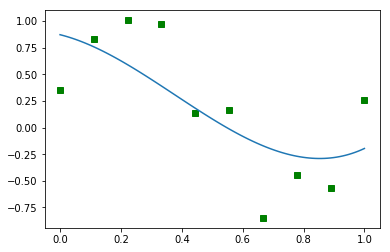

when M = 3 and lambda = 0.1:
W = [ 0.87164392 -0.71407461 -3.11600507  2.76195686]


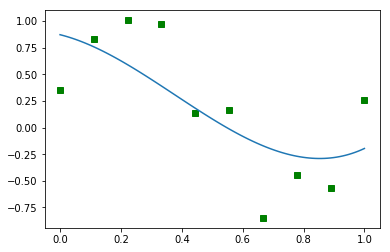

when M = 9 and lambda = 0.01:
W = [ 0.70176923  0.72815225 -2.54421672 -1.66566503 -0.51076521  0.27098218
  0.69353578  0.87048659  0.89902386  0.84563745]


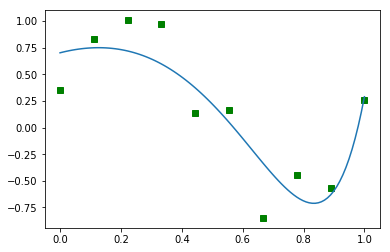

when M = 9 and lambda = 0.1:
W = [ 0.70176923  0.72815225 -2.54421672 -1.66566503 -0.51076522  0.27098219
  0.69353577  0.87048658  0.89902388  0.84563744]


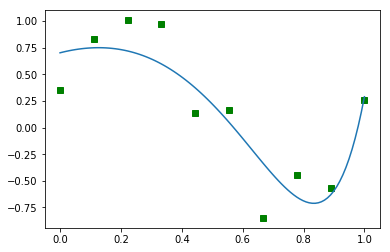

In [21]:
# loss function for numerical gradient
def getPolynomialError(X, Y, penal):
    # return error function for polynomial which is expanded to the power of M
    # which is sum of square of (yi - W·x[i])
    # return value being a function for later usage in fmin_bfgs
    return lambda W: sum((Y[i] - np.dot(W, X[i]))**2 for i in range(len(Y))) + penal * np.dot(W, W)

def regressionFit(phi, Y):
    W =  [100.0] * len(phi[0]) # hardcoding initial guess to be all 100, although doesn't matter
    return my_minimizer(getPolynomialError(phi, Y, 0.01), W, 0.04, 0.00001)

for m in (3,9):
    for lmbda in (0.01, 0.1):
        print('when M = {} and lambda = {}:'.format(m, lmbda))
        regressionPlot(x_train, y_train, m)

- lambda has no effect for p = 1 or 0, no surprise there
- greatly smoothing m = 3, somewhat smoothing m = 9
- Good way to avoid overfit when not having optimal step size and convergence threshold.
- Analytically solution is soooo much faster.


---

# PA3.2

### Regress A

In [22]:
def test_params(M, L):
    global regressionFit
    for m in M:
        for lmbda in L:
            regressionFit = lambda X,Y: (fmin_bfgs(getPolynomialError(X,Y,lmbda), [10.0]*len(X[0]), disp=0),0)
            print('when M = {} and lambda = {}:'.format(m, lmbda))
            regressionPlot(x_train, y_train, m)
        

In [23]:
x_train, y_train = getData('regressA_train.txt')

when M = 3 and lambda = 0.01:
W = [ 0.5828539   0.74224041  0.25393373  0.10616758]


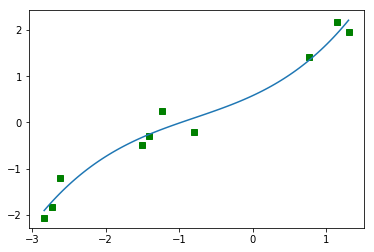

when M = 3 and lambda = 0.1:
W = [ 0.53384795  0.72004759  0.2854164   0.11829982]


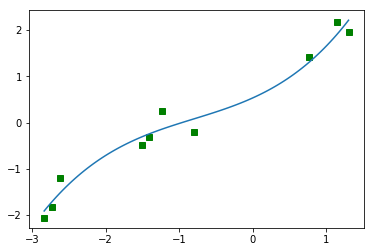

when M = 3 and lambda = 1:
W = [ 0.35423343  0.59773257  0.38237713  0.16182246]


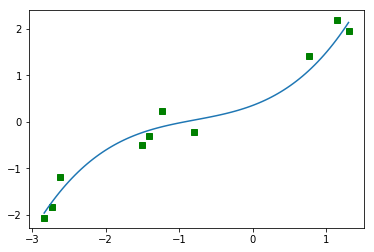

when M = 3 and lambda = 10000:
W = [  4.63876337e-05   1.89846506e-03  -2.75917966e-03   1.01310719e-02]


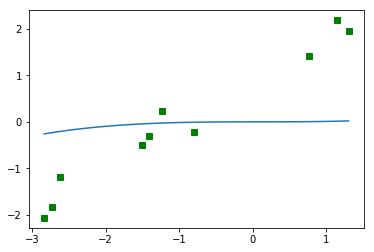

when M = 9 and lambda = 0.01:
W = [ 0.04296354  1.79520815  1.35723005 -3.16316797 -1.30215526  3.28396658
  1.54976121 -0.87906082 -0.64116186 -0.09995737]


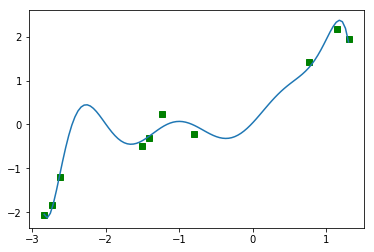

when M = 9 and lambda = 0.1:
W = [ 0.40332186  0.65611764  0.53280661  0.07303955 -0.07112969  0.5870745
  0.29402013 -0.27961303 -0.20522563 -0.03389861]


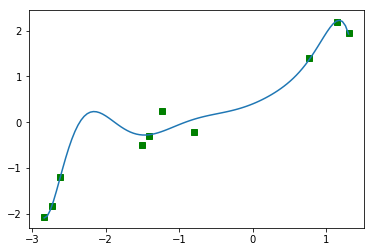

when M = 9 and lambda = 1:
W = [ 0.36305438  0.42386994  0.28496497  0.3419632   0.14486906  0.26415291
  0.11185869 -0.15371541 -0.10947776 -0.01823956]


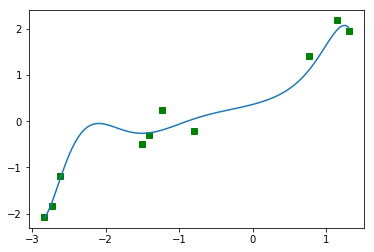

when M = 9 and lambda = 10000:
W = [ 0.00047651  0.00069731  0.0005381   0.00101829  0.00060145  0.00171027
  0.00054455  0.00294222  0.0011575   0.00022369]


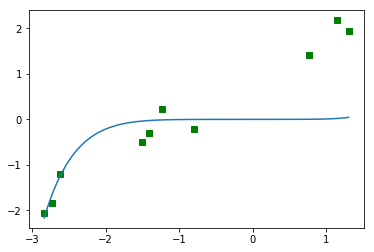

when M = 12 and lambda = 0.01:
W = [-29322.05302139  27751.42828853  95008.94853499   4583.39729755
 -69373.58084401 -22831.57132176  41829.52732463  -6116.93555092
 -48537.43080008  -7252.03242683  17498.44170028   8373.42764534
   1094.62955119]


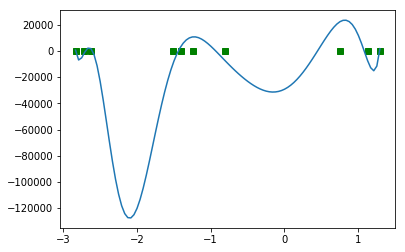

when M = 12 and lambda = 0.1:
W = [  1.11450219e+03  -2.84541871e+02   3.00693600e+05   2.50217044e+05
  -1.19160444e+05  -4.66594057e+03   7.03359643e+03  -2.10496655e+05
  -1.43216122e+05   3.90297520e+04   6.65586073e+04   2.29700927e+04
   2.62565605e+03]


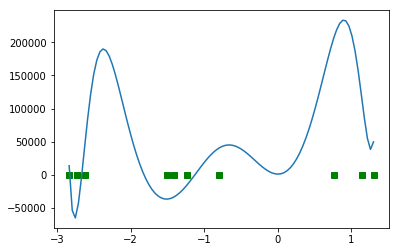

when M = 12 and lambda = 1:
W = [  23673.99945954  -62002.81251964  -67256.56062646   89677.18204026
   26557.36921948  109295.86235796    3693.84800072 -159007.20482136
  -32454.38491365   48727.12432643   17859.55018903    -413.00051768
    -525.4876996 ]


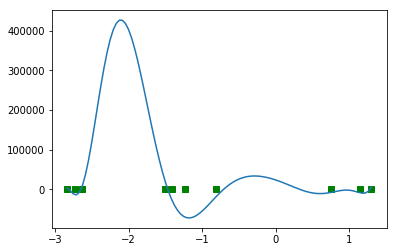

when M = 12 and lambda = 10000:
W = [ 0.00050415  0.00077198  0.0008967   0.0012158   0.00122428  0.00122295
  0.00040186  0.00330084 -0.00038947  0.00780687 -0.00589342 -0.00764042
 -0.00160344]


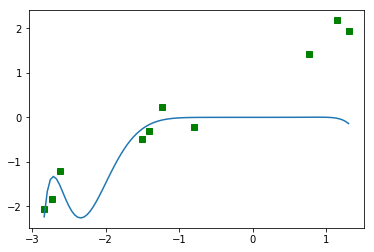

In [24]:
test_params((3,9,12), (0.01, 0.1, 1, 10000))

- As M increase, the function gains more degress of freedom. We can see that perticularly in the m=9 case where a hump emerge which seems to be un-natural.
- As lambda increase, the function smoothes. Large lambda even rescued a seem-to-be-hopeless m=12 function.

### Regress B

when M = 3 and lambda = 0.01:
W = [ 0.73589449  1.65691496  0.0521501  -0.26534284]


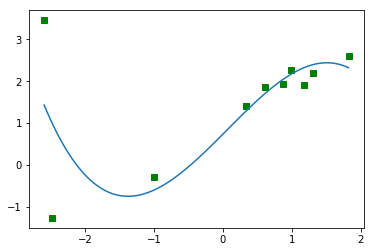

when M = 3 and lambda = 0.1:
W = [ 0.73783776  1.59479556  0.06615462 -0.25003282]


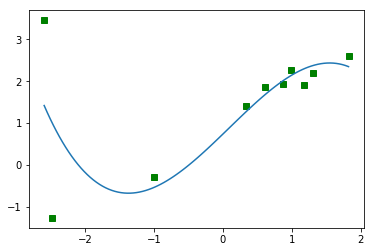

when M = 3 and lambda = 1:
W = [ 0.70860026  1.18563043  0.17046646 -0.14699221]


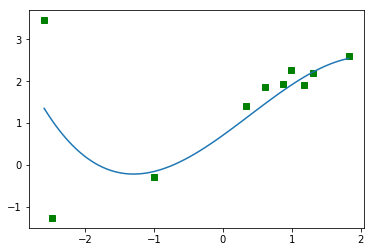

when M = 3 and lambda = 10000:
W = [ 0.00159574  0.00099861  0.00341241 -0.00118381]


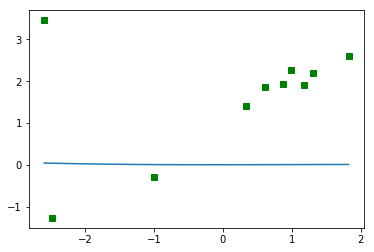

when M = 9 and lambda = 0.01:
W = [ 0.85746407  1.63544373  0.2359036   0.16976201 -0.68870697 -1.0601359
  0.59607264  0.48306447 -0.11308072 -0.06520027]


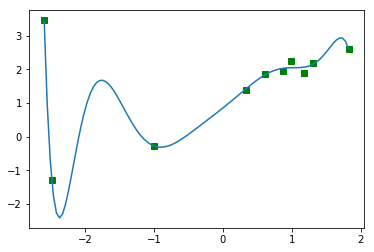

when M = 9 and lambda = 0.1:
W = [ 1.09727239  0.90049297  0.12064436  0.295292   -0.21540128 -0.01808593
 -0.13582224 -0.00736201  0.03892345  0.00520589]


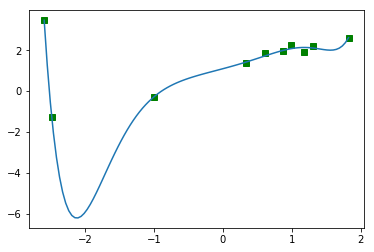

when M = 9 and lambda = 1:
W = [ 0.86922945  0.69126448  0.20589384  0.30136957 -0.05385988  0.08406871
 -0.17422443 -0.03623926  0.03642731  0.00560153]


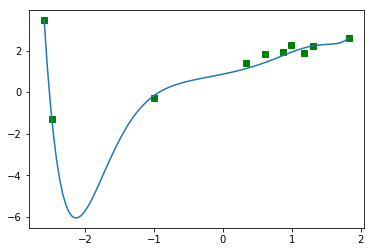

when M = 9 and lambda = 10000:
W = [ 0.00110859  0.00133658  0.00094272  0.00231338  0.00065671  0.005876
 -0.0005144   0.01479923  0.00641477 -0.0002496 ]


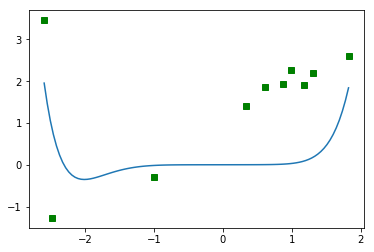

when M = 12 and lambda = 0.01:
W = [   8422.41195281  -64451.71660138   86233.14309821   63515.25293279
 -129749.96288341   16255.87507296   55043.9639333   -34119.11960659
  -29713.34251808   23914.99498406   11258.46866232   -4300.36367351
   -1687.99182233]


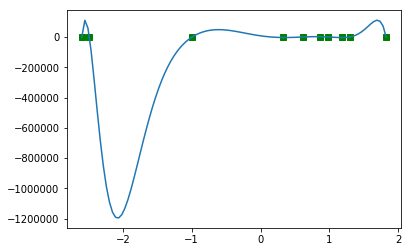

when M = 12 and lambda = 0.1:
W = [ 126893.19879855 -185687.29887712  137473.60276254  -54847.95673215
     578.92359641   -2685.51979315 -144185.19166556  213707.31830013
 -218894.11936535   35167.85029248  106238.32356724  -19128.42657258
  -14049.20322208]


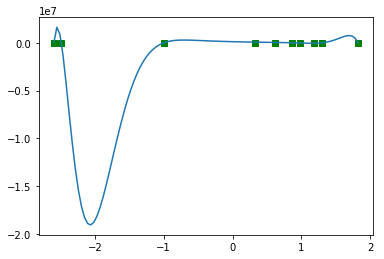

when M = 12 and lambda = 1:
W = [ -563.82558087  -869.98219692  2073.43911772  -428.49781154 -1319.56828125
  1266.20017151    89.34962355   281.78927511   193.29153893  -602.02852157
  -168.94299925   124.34737379    38.38481638]


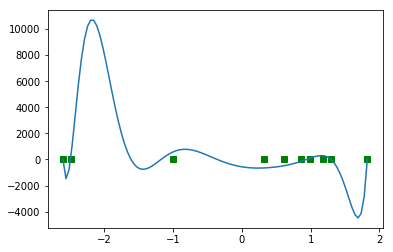

when M = 12 and lambda = 10000:
W = [ 0.00117277  0.00106156  0.00095502  0.00122393  0.00118241  0.00164407
  0.00129758  0.00236696  0.00095675  0.00384832 -0.00079504  0.00099586
  0.00075437]


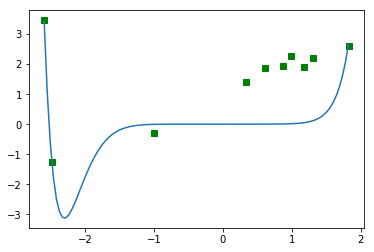

In [25]:
x_train, y_train = getData('regressB_train.txt')
test_params((3,9,12), (0.01, 0.1, 1, 10000))

- Because of not sure how is B's true function should look like (assuming noise model), it is difficult to tell if there exists an outlier (or which is one is an outlier).
- Clearly, large M tend to fit towards outliers more than small M functions.
- Notice that with small lambda, an float INF overflow happend. Therefore, having a lambda should help with normalizing the size of number during calculation as well.

### I would consider the case where M = 3 and lambda = 1 to be the best.
### I think I am ready to do validate now.

when M = 3 and lambda = 1:
W = [ 0.93579805  0.94444988  0.04282382  0.03170386]


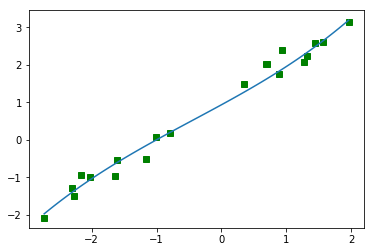

In [26]:
x_train, y_train = getData('regress_validate.txt')
test_params([3],[1])

### Looks okay to me.. Let's now try other parameters and see if there's any combination which is better

when M = 3 and lambda = 0.01:
W = [ 1.0970913   1.0594047  -0.02921287 -0.00613647]


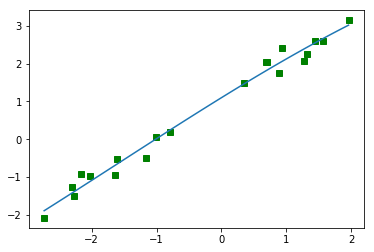

when M = 3 and lambda = 0.1:
W = [ 1.0797631   1.04757726 -0.02145953 -0.00216621]


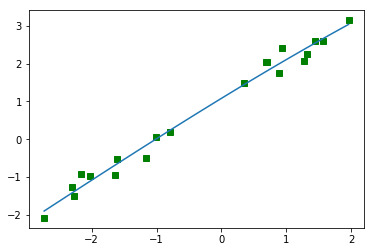

when M = 3 and lambda = 1:
W = [ 0.93579805  0.94444988  0.04282382  0.03170386]


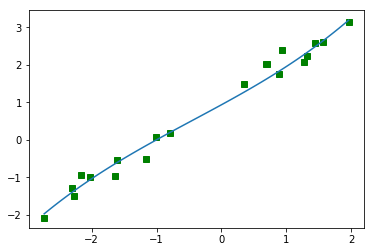

when M = 3 and lambda = 10000:
W = [ 0.00146496  0.00425899 -0.0001132   0.01411358]


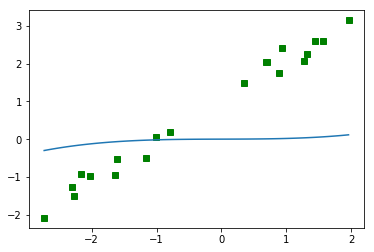

when M = 9 and lambda = 0.01:
W = [ 1.09644524  1.18702769  0.47240872  0.02780702 -0.91703453 -0.20684187
  0.42375611  0.11529716 -0.05628596 -0.01723884]


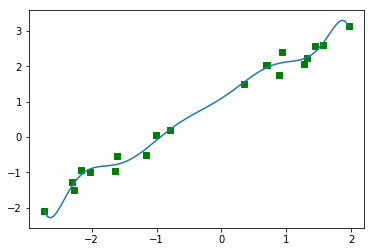

when M = 9 and lambda = 0.1:
W = [ 1.17605376  1.04789533  0.06868425  0.20404372 -0.41730105 -0.22274842
  0.21220886  0.08319223 -0.02837121 -0.01025038]


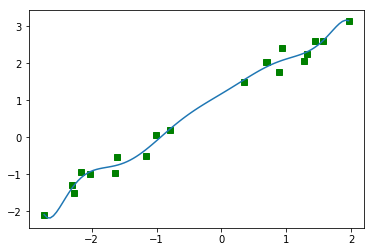

when M = 9 and lambda = 1:
W = [  9.20806055e-01   8.44479584e-01   1.52267205e-01   2.90679225e-01
  -7.51514943e-02  -1.33273502e-01   1.27191649e-03   1.89279163e-02
   2.75658454e-03  -4.83354637e-05]


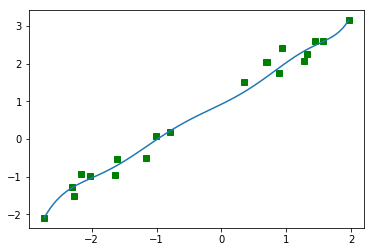

when M = 9 and lambda = 10000:
W = [ 0.00157238  0.00211094  0.00153388  0.00351315  0.00169468  0.00713615
  0.00151782  0.01360127  0.00578888  0.00050493]


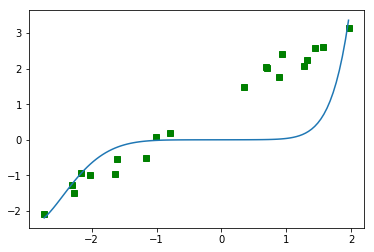

when M = 12 and lambda = 0.01:
W = [   7452.85325404   37187.31130556 -103326.45426161 -165526.49642367
  216047.74113878  262425.63021238 -144987.97036426 -179928.05669398
   27908.72474623   54374.26938989    3708.35962091   -5875.56500157
   -1168.52153065]


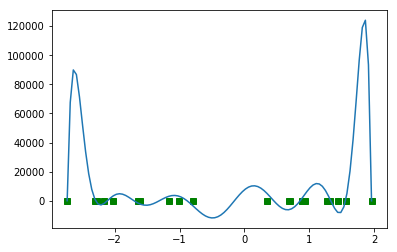

when M = 12 and lambda = 0.1:
W = [  1.22350828  -2.4725498    0.46627828   3.14897383   2.27894211
   8.70148458  -3.23485694 -11.26489515   0.13683262   4.34168551
   0.63158492  -0.53078862  -0.12745375]


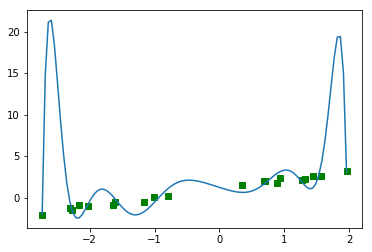

when M = 12 and lambda = 1:
W = [ 0.99893604  0.6973126   0.44893144  1.15862265 -0.22796552  0.62026503
 -0.5640003  -1.99293177  0.11960781  0.97560403  0.13496095 -0.13476119
 -0.0327184 ]


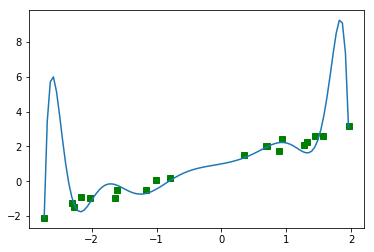

when M = 12 and lambda = 10000:
W = [ 0.00148499  0.00199041  0.00165693  0.00272785  0.00253628  0.00463782
  0.00369728  0.00876193  0.00469672  0.01339181  0.00339696 -0.00287538
 -0.00089495]


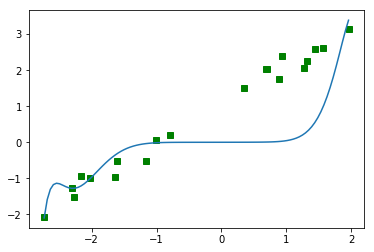

In [27]:
test_params((3,9,12), (0.01, 0.1, 1, 10000))

### the case of M = 9 and lambda = 1, which is the case where big M conpensated by big lambda, also works considerably well on the validation set. 